# Лабораторная работа №3

# Задание

Изучить примеры в тетрадках: Lab3_Ex1 MR_PolR.ipynb, Lab3_Ex2 SR-MR-PolR.ipynb
Реализовать настройку окружения (см. Как подготовить окружение.pdf).

Изучить примеры в тетрадках:
Lab3_Ex3 SR_PolR_1Hot-Code.ipynb — еще пример на полиномиальную регрессии + горячее кодирование (Pandas) и демонстрация как существенно это влияет на качество модели ML
Lab3_Ex4 LR ElasticNet-GridSearch.ipynb — пример на ElasticNet

1. В соответствии с индивидуальным вариантом загрузить датасет (см. ML 3 semestr datasets) для решения задачи регрессии, выполнить предварительную обработку и разведочный анализ данных (EDA).
2. Выделить целевой признак и предикторы, разбить данные на обучающую и тестовую выборку.
3. Решить задачу регрессии на ваших данных с использованием моделей sklearn (простая линейная регрессия + L1, L2; множественная линейная регрессия + L1, L2), для моделей с регуляризациями подберите гиперпараметр.
4. Решить задачу регрессии на ваших данных с использованием моделей sklearn (Полиномиальная регрессия + L1, L2), для моделей с регуляризациями подберите гиперпараметр.
5. Вычислить значения метрик R2, MAE, MSE, RMSE, MAPE для всех обученных моделей. Выбрать лучшую модель.
6. Реализовать пайплайн при построении модели регрессии.
7. Самостоятельно реализовать вычисление всех используемых метрик (в виде функций, принимающих два аргумента). Привести в таблице метрики, вычисленные с использование библиотеки Scikit-learn и соответствующими пользовательскими функциями.
8. Решить задачу регрессии на ваших данных с использованием моделей sklearn (простая линейная регрессия + L1, L2, ElasticNet; множественная линейная регрессия + L1, L2, ElasticNet), для моделей с регуляризациями подберите гиперпараметр. Применить горячее кодирование (Pandas).
9. Вычислить значения метрик R2, MAE, MSE, RMSE, MAPE для всех обученных моделей. Выбрать лучшую модель.
10. *самостоятельно реализовать (желательно в виде класса) модель линейной регрессии с регуляризацией (L1 и L2)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

# Пункт 1

В соответствии с индивидуальным вариантом загрузить датасет (см. ML 3 semestr datasets) для решения задачи регрессии, выполнить предварительную обработку и разведочный анализ данных (EDA).

## Предварительная обработка данных

In [2]:
import pandas as pd
df = pd.read_csv('../../Datasets/Lab3_DataSet3.csv')

In [3]:
df.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011.0,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014.0,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Volkswagen,Golf,1998.0,Hatchback,1.0,1400.0,Petrol,Manual,2200.0
3,Renault,Laguna,2012.0,Universal,110000.0,1500.0,Diesel,Manual,6550.0
4,Opel,Astra,2006.0,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0


In [4]:
# переименовываем некоторые столбцы
renamer = {'Make': 'Mark', 
           'Style': 'Type',
           'Engine_capacity(cm3)': 'Engine_capacity_cm3'}
df = df.rename(renamer, axis='columns')

In [5]:
# узнаём информацию о столбцах
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41007 entries, 0 to 41006
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Mark                 41007 non-null  object 
 1   Model                40671 non-null  object 
 2   Year                 40771 non-null  float64
 3   Type                 40938 non-null  object 
 4   Distance             40889 non-null  float64
 5   Engine_capacity_cm3  41007 non-null  float64
 6   Fuel_type            41007 non-null  object 
 7   Transmission         40779 non-null  object 
 8   Price(euro)          41007 non-null  float64
dtypes: float64(4), object(5)
memory usage: 2.8+ MB


**Вывод:** 
- В столбцах model, year, type, distance, transmission присутствуют пропущенные значения
- столбцы year, distance, engine_capacity, price имеют тип float, а не тип int

### Избавление от дубликатов

In [6]:
df.duplicated().sum()


3589

In [7]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

### Заполнение пропущенных значений

In [8]:
def fill_na(df: pd.DataFrame, need_column: str, *parameters):
    na_indexes = df[df[need_column].isna()].index

    for auto in na_indexes:
        param1 = df[parameters[0]][auto]
        param2 = df[parameters[1]][auto]
        query = df.query(f'{parameters[0]} == "{param1}" & {parameters[1]} == "{param2}"')
        try: df[need_column][auto] = query[need_column].mode().iat[0]
        except IndexError: continue

In [9]:
# заполняем столбец Модели
fill_na(df,'Model','Mark','Type')

# заполняем столбец года
fill_na(df, 'Year', 'Mark', 'Model')

# заполняем тип
fill_na(df,'Type','Mark','Model')

# заполняем пробег
fill_na(df,'Distance','Mark','Model')

#заполняем коробку передач
fill_na(df,'Transmission','Mark','Model')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37418 entries, 0 to 37417
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Mark                 37418 non-null  object 
 1   Model                37418 non-null  object 
 2   Year                 37418 non-null  float64
 3   Type                 37418 non-null  object 
 4   Distance             37418 non-null  float64
 5   Engine_capacity_cm3  37418 non-null  float64
 6   Fuel_type            37418 non-null  object 
 7   Transmission         37413 non-null  object 
 8   Price(euro)          37418 non-null  float64
dtypes: float64(4), object(5)
memory usage: 2.6+ MB


Заменяем столбцы с типами float на тип int

In [11]:
columns = ['Year','Distance','Engine_capacity_cm3','Price(euro)']

for column in columns:
    df[column] = df[column].astype(int)

Убираем строчки с неизвестным столбцом Transmission и заменяем значения в нём на числа

In [12]:
df = df.dropna()

to_replace = {
    'Manual': 1,
    'Automatic': 2
}
df['Transmission'] = df['Transmission'].replace(to_replace)

## EDA

In [13]:
df.describe()

,Year,Distance,Engine_capacity_cm3,Transmission,Price(euro)
count,37413.000000,3.741300e+04,37413.000000,37413.000000,3.741300e+04
mean,2007.722503,4.742012e+05,1858.713602,1.443910,9.573405e+03
std,8.285509,4.582109e+06,707.027355,0.496851,5.273025e+04
min,1900.000000,0.000000e+00,0.000000,1.000000,1.000000e+00
25%,2004.000000,9.000000e+04,1499.000000,1.000000,3.333000e+03
50%,2009.000000,1.700000e+05,1800.000000,1.000000,6.499000e+03
75%,2014.000000,2.300000e+05,2000.000000,2.000000,1.180000e+04
max,2021.000000,1.000000e+08,9999.000000,2.000000,1.000000e+07


In [14]:
columns = df.describe().columns
outlier = df[columns]

Q1 = outlier.quantile(0.25)
Q3 = outlier.quantile(0.75)
IQR = Q3 - Q1

data = outlier[~( (outlier < (Q1 - 1.5*IQR)) | (outlier > (Q3 + 1.5*IQR)) ).any(axis=1)]
data.head()

,Year,Distance,Engine_capacity_cm3,Transmission,Price(euro)
0,2011,195000,1800,2,7750
1,2014,135000,1500,1,8550
2,1998,1,1400,1,2200
3,2012,110000,1500,1,6550
4,2006,200000,1600,1,4100


In [15]:
indexes = list(data.index.values)

data = df[df.index.isin(indexes)]
data.head()

,Mark,Model,Year,Type,Distance,Engine_capacity_cm3,Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000,1800,Hybrid,2,7750
1,Renault,Grand Scenic,2014,Universal,135000,1500,Diesel,1,8550
2,Volkswagen,Golf,1998,Hatchback,1,1400,Petrol,1,2200
3,Renault,Laguna,2012,Universal,110000,1500,Diesel,1,6550
4,Opel,Astra,2006,Universal,200000,1600,Metan/Propan,1,4100


In [16]:
data.to_csv('../../Datasets/Lab3_DataSet3_Preprocesed.csv')

In [17]:
def compare_data(old_df: pd.DataFrame, new_df: pd.DataFrame, column: str, figsize: tuple[float,float] = (10,4)):
    columns_to_view = {
        f'{column} (before)': old_df[column],
        f'{column} (after)': new_df[column]
    }
    view_data = pd.DataFrame(columns_to_view)
    view_data.hist(figsize=figsize)

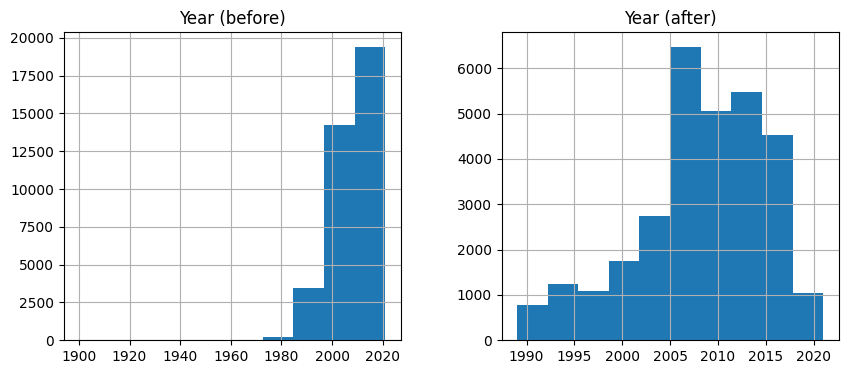

In [18]:
compare_data(df,data,'Year')

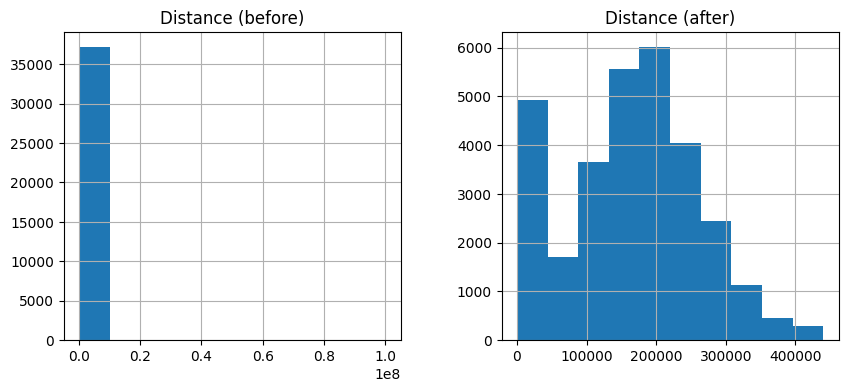

In [19]:
compare_data(df,data,'Distance')

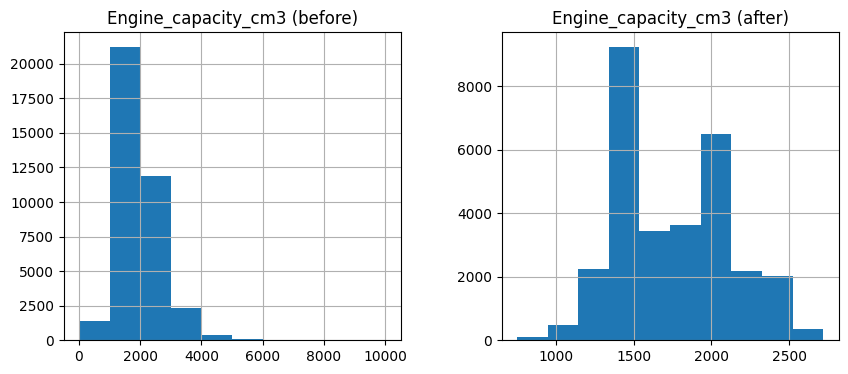

In [20]:
compare_data(df,data,'Engine_capacity_cm3')

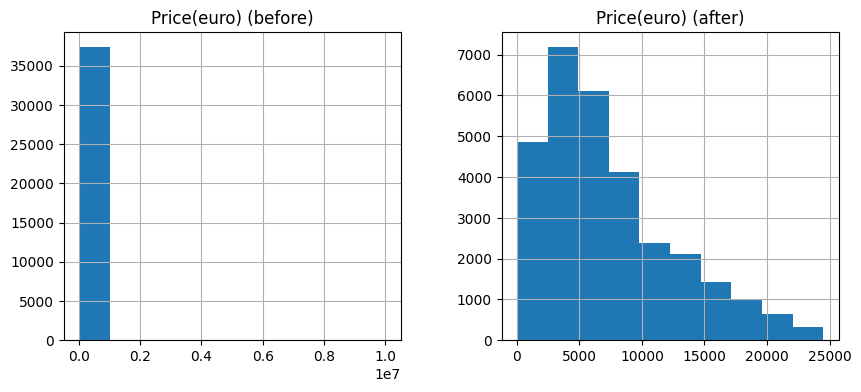

In [21]:
compare_data(df,data,'Price(euro)')

Посмотрим, как коррелирует цена от других данных

In [22]:
data[columns].corr()

,Year,Distance,Engine_capacity_cm3,Transmission,Price(euro)
Year,1.000000,-0.247004,-0.136392,0.384729,0.695346
Distance,-0.247004,1.000000,0.125226,-0.108576,-0.191288
Engine_capacity_cm3,-0.136392,0.125226,1.000000,0.332244,0.265545
Transmission,0.384729,-0.108576,0.332244,1.000000,0.560690
Price(euro),0.695346,-0.191288,0.265545,0.560690,1.000000


# Пункт 2

### Выбираем целевой признак и предикторы

In [ ]:
# целевой признак - цена
Y = data['Price(euro)']
# предикторы
X = data[columns].drop('Price(euro)',axis=1)

In [ ]:
Y

0        7750
1        8550
2        2200
3        6550
4        4100
         ... 
37413    4400
37414    7000
37415    4500
37416    4000
37417    4000
Name: Price(euro), Length: 30174, dtype: int32

In [ ]:
X

,Year,Distance,Engine_capacity_cm3,Transmission
0,2011,195000,1800,2
1,2014,135000,1500,1
2,1998,1,1400,1
3,2012,110000,1500,1
4,2006,200000,1600,1
...,...,...,...,...
37413,2002,225000,1800,1
37414,2015,89000,1500,1
37415,2009,225,1500,1
37416,2006,370000,2000,1


In [ ]:
data.to_csv('../../Datasets/Lab3_DataSet3_Preprocessed_NotDummies.csv')

### Разделяем данные на обучающие и тестовые выборки

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2) # stratify - сохранение соотн призн

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((24139, 4), (24139,), (6035, 4), (6035,))

# Пункт 3

Решить задачу регрессии на данных с использованием моделей sklearn (простая линейная регрессия + L1, L2; множественная линейная регрессия + L1, L2), для моделей с регуляризациями подберите гиперпараметр

## Простая линейная регрессия

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import numpy as np
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt

In [ ]:
metrics_data = pd.DataFrame(columns=['Name','MSE','MAE','RMSE','MAPE','R^2'])
def metrics(
        title,y_test,y_pred,
        write_in_metrics: bool = True
        ):
    global metrics_data 
    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = sqrt(MSE)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    R2 = r2_score(y_test,y_pred)

    print(title)
    print(f'MSE = {MSE}')
    print(f'MAE = {MAE}')
    print(f'RMSE = {RMSE}')
    print(f'MAPE = {MAPE}')
    print(f'R^2 = {R2}')
    print('')
    
    if write_in_metrics:
        metrics_data.loc[len(metrics_data.index)] = [title,MSE,MAE,RMSE,MAPE,R2]

In [ ]:
parameters = {'alpha': np.arange(0, 1.1, 0.1)}

for column in X.columns:
    x_one_sign_train = X_train[column].values.reshape(-1,1)
    x_one_sign_test = X_test[column].values.reshape(-1,1)

    lr = LinearRegression().fit(x_one_sign_train,Y_train)
    Y_pred = lr.predict(x_one_sign_test)
    metrics(column,Y_test,Y_pred)

    lasso_optimal = GridSearchCV(Lasso(),parameters).fit(x_one_sign_train,Y_train)
    y_pred = lasso_optimal.predict(x_one_sign_test)
    metrics(column + ' + L1',Y_test,y_pred)

    ridge_optimal = GridSearchCV(Ridge(),parameters).fit(x_one_sign_train,Y_train)
    y_pred = ridge_optimal.predict(x_one_sign_test)
    metrics(column + ' + L2',Y_test,y_pred)

Year
MSE = 13943323.912095802
MAE = 2876.6011320646794
RMSE = 3734.0760453016755
MAPE = 1.5131043995700264
R^2 = 0.488512695983749



Year + L1
MSE = 13943328.46930823
MAE = 2876.5905003582607
RMSE = 3734.0766555211785
MAPE = 1.5131062903138817
R^2 = 0.4885125288101029

Year + L2
MSE = 13943324.013385015
MAE = 2876.600894652216
RMSE = 3734.076058864497
MAPE = 1.5131044417914556
R^2 = 0.4885126922681252

Distance
MSE = 26196689.792699415
MAE = 4059.0981048251947
RMSE = 5118.270195358918
MAPE = 2.666668210122828
R^2 = 0.039018650022608625

Distance + L1
MSE = 26196689.79374953
MAE = 4059.0981054548306
RMSE = 5118.270195461503
MAPE = 2.6666682074302055
R^2 = 0.039018649984086995

Distance + L2
MSE = 26196689.792699415
MAE = 4059.0981048251942
RMSE = 5118.270195358918
MAPE = 2.6666682101228294
R^2 = 0.039018650022608625

Engine_capacity_cm3
MSE = 25134341.76074329
MAE = 4013.3630710194634
RMSE = 5013.416176694619
MAPE = 2.8267866041055663
R^2 = 0.07798909453195768

Engine_capacity_cm3 + L1
MSE = 25134342.1672714
MAE = 4013.363062103662
RMSE = 5013.4162172386405
MAPE = 2.8267857359954407
R^2 = 0.07798907961916013

Engine_

## Множественная линейная регрессия

In [ ]:
parameters = {'alpha': np.arange(0, 1.1, 0.1)}

lr = LinearRegression().fit(X_train,Y_train)
Y_pred = lr.predict(X_test)
metrics('Множественная линейная регрессия',Y_test,Y_pred)

lasso_optimal = GridSearchCV(Lasso(),parameters).fit(X_train,Y_train)
y_pred = lasso_optimal.predict(X_test)
metrics('Множественная линейная регрессия + L1',Y_test,y_pred)

ridge_optimal = GridSearchCV(Ridge(),parameters).fit(X_train,Y_train)
y_pred = ridge_optimal.predict(X_test)
metrics('Множественная линейная регрессия + L2',Y_test,y_pred)

Множественная линейная регрессия
MSE = 9175720.88416019
MAE = 2246.213235182986
RMSE = 3029.145239858959
MAPE = 1.8721609285677554
R^2 = 0.6634041662495331



Множественная линейная регрессия + L1
MSE = 9175720.884160224
MAE = 2246.2132351829787
RMSE = 3029.1452398589645
MAPE = 1.8721609285675842
R^2 = 0.663404166249532

Множественная линейная регрессия + L2
MSE = 9175722.28570069
MAE = 2246.212583200361
RMSE = 3029.145471201522
MAPE = 1.8721902399845496
R^2 = 0.6634041148363855



# Пункт 4

Решить задачу регрессии на ваших данных с использованием моделей sklearn (Полиномиальная регрессия + L1, L2), для моделей с регуляризациями подберите гиперпараметр.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
p = PolynomialFeatures()
X_train_p = p.fit_transform(X_train)
X_test_p = p.fit_transform(X_test)

In [ ]:
parameters = {'alpha': np.arange(0, 1.1, 0.1)}

lr = LinearRegression().fit(X_train_p, Y_train)
y_pred = lr.predict(X_test_p)
metrics('Полиномиальная регрессия',Y_test,y_pred)

lasso_optimal = GridSearchCV(Lasso(),parameters).fit(X_train,Y_train)
y_pred = lasso_optimal.predict(X_test)
metrics('Полиномиальная регрессия + L1',Y_test,y_pred)

ridge_optimal = GridSearchCV(Ridge(),parameters).fit(X_train,Y_train)
y_pred = ridge_optimal.predict(X_test)
metrics('Полиномиальная регрессия + L2',Y_test,y_pred)

Полиномиальная регрессия
MSE = 6080419.64765626
MAE = 1773.3007870828305
RMSE = 2465.8506945182753
MAPE = 1.1731809750533904
R^2 = 0.7769500678264258



Полиномиальная регрессия + L1
MSE = 9175720.884160224
MAE = 2246.2132351829787
RMSE = 3029.1452398589645
MAPE = 1.8721609285675842
R^2 = 0.663404166249532

Полиномиальная регрессия + L2
MSE = 9175722.28570069
MAE = 2246.212583200361
RMSE = 3029.145471201522
MAPE = 1.8721902399845496
R^2 = 0.6634041148363855



# Пункт 6

Реализовать пайплайн при построении модели регрессии.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet

In [ ]:
Input = [
    ('StandardScaler',StandardScaler()),
    ('Polynomial',PolynomialFeatures()),
    ('model',LinearRegression())
]

pipeline = Pipeline(Input)
pipeline

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('Polynomial', PolynomialFeatures()),
                ('model', LinearRegression())])

In [ ]:
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('Polynomial', PolynomialFeatures()),
                ('model', LinearRegression())])

In [ ]:
y_pipeline_pred = pipeline.predict(X_test)
metrics('Пайплайн',Y_test,y_pipeline_pred)

Пайплайн
MSE = 6080389.294181527
MAE = 1773.3115754412736
RMSE = 2465.844539743235
MAPE = 1.1731952635187146
R^2 = 0.7769511812924155



# Пункт 7

Самостоятельно реализовать вычисление всех используемых метрик (в виде функций, принимающих два аргумента). Привести в таблице метрики, вычисленные с использование библиотеки Scikit-learn и соответствующими пользовательскими функциями.

In [ ]:
def MSE(y_true: np.ndarray, y_pred: np.ndarray): 
    return np.sum((y_true - y_pred)**2) / y_true.shape[0]

def MAE(y_true: np.ndarray, y_pred: np.ndarray):
    return np.sum(np.absolute(y_true - y_pred)) / y_true.shape[0]

def RMSE(y_true: np.ndarray, y_pred: np.ndarray): 
    return sqrt(MSE(y_true,y_pred))

def MAPE(y_true: np.ndarray, y_pred: np.ndarray): 
    return np.sum(np.absolute((y_true - y_pred) / y_true)) / y_true.shape[0]

def R2(y_true: np.ndarray, y_pred: np.ndarray):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

In [ ]:
# test
A = np.array([73, 25, 29, 57, 37, 76, 92, 74, 32, 28])
B = np.array([50, 42, 31, 64, 41, 79,  4, 26, 53, 30])
metrics('Sklearn metrics',A,B,write_in_metrics=False)

print('My metrics')
print(f'MSE = {MSE(A,B)}')
print(f'MAE = {MAE(A,B)}')
print(f'RMSE = {RMSE(A,B)}')
print(f'MAPE = {MAPE(A,B)}')
print(f'R^2 = {R2(A,B)}')
print('')

Sklearn metrics
MSE = 1138.9
MAE = 21.5
RMSE = 33.747592506725574
MAPE = 0.3667271779462214
R^2 = -1.0395408391683527

My metrics
MSE = 1138.9
MAE = 21.5
RMSE = 33.747592506725574
MAPE = 0.3667271779462214
R^2 = -1.0395408391683527



# Пункт 8

Решить задачу регрессии на ваших данных с использованием моделей sklearn (простая линейная регрессия + L1, L2, ElasticNet; множественная линейная регрессия + L1, L2, ElasticNet), для моделей с регуляризациями подберите гиперпараметр. Применить горячее кодирование (Pandas)

## Горячее кодирование

In [ ]:
data_hot = pd.get_dummies(data.drop('Model',axis=1),dtype=int)
Y_hot = data_hot['Price(euro)']
X_hot = data_hot[data_hot.describe().columns].drop('Price(euro)',axis=1)

X_train_hot, X_test_hot, Y_train_hot, Y_test_hot = train_test_split(X_hot,Y_hot,test_size=0.2)

X_train_hot.shape, Y_train_hot.shape, X_test_hot.shape, Y_test_hot.shape

((24139, 99), (24139,), (6035, 99), (6035,))

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_hot)

StandardScaler()

In [ ]:
parameters = {'alpha': np.arange(0.1, 1.1, 0.4)}

elastic_model = RandomizedSearchCV(ElasticNet(),parameters).fit(X_train_hot,Y_train_hot)
y_pred = elastic_model.predict(X_test_hot)
metrics('ElasticNet',Y_test_hot,y_pred)

ElasticNet
MSE = 8399804.501871325
MAE = 2077.6111257915927
RMSE = 2898.2416224102717
MAPE = 1.5639283044247807
R^2 = 0.6951366722566401



In [ ]:
lasso_optimal = RandomizedSearchCV(Lasso(),parameters).fit(X_train_hot,Y_train_hot)
y_pred = lasso_optimal.predict(X_test_hot)
metrics('Горячее кодирование + L1',Y_test_hot,y_pred)

Горячее кодирование + L1
MSE = 7688921.461102164
MAE = 1972.7475966880877
RMSE = 2772.8904524164245
MAPE = 1.631490253821843
R^2 = 0.7209375310024506



In [ ]:
ridge_optimal = RandomizedSearchCV(Ridge(),parameters).fit(X_train_hot,Y_train_hot)
y_pred = ridge_optimal.predict(X_test_hot)
metrics('Горячее кодирование + L2',Y_test_hot,y_pred)

Горячее кодирование + L2
MSE = 7688617.26424581
MAE = 1972.4500690446212
RMSE = 2772.8355999311984
MAPE = 1.6318423764047438
R^2 = 0.7209485715529653



# Пункт 9

Вычислить значения метрик R2, MAE, MSE, RMSE, MAPE для всех обученных моделей. Выбрать лучшую модель.

In [ ]:
metrics_data.sort_values(by=['R^2','MSE','MAE','MAPE'], ascending=False)

,Name,MSE,MAE,RMSE,MAPE,R^2
18,Пайплайн,6.080389e+06,1773.311575,2465.844540,1.173195,0.776951
15,Полиномиальная регрессия,6.080420e+06,1773.300787,2465.850695,1.173181,0.776950
21,Горячее кодирование + L2,7.688617e+06,1972.450069,2772.835600,1.631842,0.720949
20,Горячее кодирование + L1,7.688921e+06,1972.747597,2772.890452,1.631490,0.720938
19,ElasticNet,8.399805e+06,2077.611126,2898.241622,1.563928,0.695137
12,Множественная линейная регрессия,9.175721e+06,2246.213235,3029.145240,1.872161,0.663404
13,Множественная линейная регрессия + L1,9.175721e+06,2246.213235,3029.145240,1.872161,0.663404
16,Полиномиальная регрессия + L1,9.175721e+06,2246.213235,3029.145240,1.872161,0.663404
14,Множественная линейная регрессия + L2,9.175722e+06,2246.212583,3029.145471,1.872190,0.663404
17,Полиномиальная регрессия + L2,9.175722e+06,2246.212583,3029.145471,1.872190,0.663404


Полиномиальная регрессия и пайплайн являются лучшими моделями из 22х, которые применялись на данных, за ней идёт горячее кодирование с регуляризацией, ну а замыкает топ-5 ElasticNet

Худшими моделями являются простые регрессии из параметров distance и engine_capacity_cm3

# Пункт 10

Самостоятельно реализовать (желательно в виде класса) модель линейной регрессии с регуляризацией (L1 и L2)

In [ ]:
class MyLinearRegression:
    def fit(self,x: pd.DataFrame, y: pd.Series):
        x_t = x.transpose()
        x_t_on_x = np.dot(x_t, x) # x_t * x
        x_t_on_x_inverse = np.linalg.inv(x_t_on_x) # (x_t * x)^-1
        w = np.dot(x_t_on_x_inverse,x_t) # (x_t * x)^-1 * x^t
        self.w = np.dot(w,y)  # (x_t * x)^-1 * x^t * y
        return self

    def predict(self,x):
        return np.dot(x,self.w)

In [ ]:
lr1 = MyLinearRegression().fit(X_train,Y_train)
y_pred1 = lr1.predict(X_test)
metrics('моя регрессия',Y_test,y_pred1,False)

lr2 = LinearRegression().fit(X_train,Y_train)
y_pred2 = lr2.predict(X_test)
metrics('настоящая регрессия',Y_test,y_pred2,False)

моя регрессия
MSE = 17465285.836358294
MAE = 3278.4324246881474
RMSE = 4179.1489368480625
MAPE = 2.172938112472845
R^2 = 0.359315467199143

настоящая регрессия
MSE = 9175720.88416019
MAE = 2246.213235182986
RMSE = 3029.145239858959
MAPE = 1.8721609285677554
R^2 = 0.6634041662495331

